1. `conda create -n dream_env -f environment.yaml`
2. `conda activate dream_env`

# Dream Model Testing

In [1]:
import os
os.chdir('/home/jovyan')

In [ ]:
import pandas as pd
import numpy as np
import random
import warnings
from utils import *
from preprocessing.datasets import *

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 50)

## Data Preparation

In [3]:
# quality_df_dir = 'data/quality_scores_per_subject.csv'
# features_dir = "data/features_df/"
# info_dir = "data/participant_info.csv"

In [4]:
# clean_df, new_features, good_quality_sids = data_preparation(
#     threshold = 0.2, 
#     quality_df_dir = quality_df_dir,
#     features_dir = features_dir,
#     info_dir = info_dir
# )

# print(clean_df.shape)
# print(len(new_features))

Read from processed files:

In [5]:
import json


clean_df = pd.read_csv('data/processed/clean_df.csv')

with open("data/processed/new_features.json", "r") as f:
    new_features = json.load(f)

good_quality_sids = []
with open("data/processed/good_quality_sids.txt", "r") as f:
    for line in f.readlines():
        good_quality_sids.append(line.split('\n')[0])

print(clean_df)
print(new_features)
print(good_quality_sids)

       PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN   HRV_RMSSD    HRV_SDSD  ...  Hypopnea  Multiple_Events  artifact   sid   BMI
0          87.451445   706.554878  267.856258  351.154277  355.627540  ...       0.0              0.0         0  S003  51.0
1          84.687304   729.296875  280.299933  416.686698  422.114301  ...       0.0              0.0         1  S003  51.0
2          90.889185   675.872093  224.392912  307.124526  310.704819  ...       0.0              0.0         1  S003  51.0
3          79.140186   783.361486  303.274460  394.236775  399.794171  ...       0.0              0.0         1  S003  51.0
4          90.383327   697.265625  297.089740  386.889187  391.164017  ...       0.0              0.0         1  S003  51.0
...              ...          ...         ...         ...         ...  ...       ...              ...       ...   ...   ...
77523      61.392727   982.219828  132.432765  154.679608  157.518003  ...       0.0              0.0         0  S102  26.0
77524   

Get DataFrame and final features. The 'sid' of training set, validation set, and test set are also splitted.

In [6]:
good_quality_sids = [sid for sid in good_quality_sids if sid in clean_df['sid'].values]  # check the existence

sw_df, final_features = split_data(clean_df, good_quality_sids, new_features)

random.seed(4487)

train_sids = random.sample(good_quality_sids, 56)

remaining_sids = [subj for subj in good_quality_sids if subj not in train_sids]

val_sids = random.sample(remaining_sids, 8)

test_sids = [subj for subj in remaining_sids if subj not in val_sids]

Choose random effect (the selection has no effects to the prediction currently), and get actual training, validation, and test set while the training set are resampled using 'SMOTE' since the class is unbalanced:

In [7]:
group_vars = ['AHI_Severity', 'Obesity']

group_var = [group_vars[0]]  # selecting Apnea as random effect

(X_train_resampled, y_train_resampled, group_train_resampled), \
(X_train, y_train, group_train), \
(X_val, y_val, group_val), \
(X_test, y_test, group_test) = process_and_resample_data(
    sw_df, train_sids, val_sids, test_sids, final_features, group_var
)

## Model Testing

In [ ]:
from dream_models.dream_lightgbm import *
from dream_models.dream_gpboost import *
from dream_models.dream_lstm import *
from dream_models.dream_knn_baseline import *
from dream_models.dream_decision_tree_baseline import *
from dream_models.dream_random_forest_baseline import *
from dream_models.dream_fttransformer import *

### Baseline Models

#### k-NN

In [9]:
final_knn_model = knn_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [02:03<00:00,  2.46s/trial, best loss: -0.6362175194213769]
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'uniform'}


Training score:

[[25228  9058]
 [ 6705 16548]]


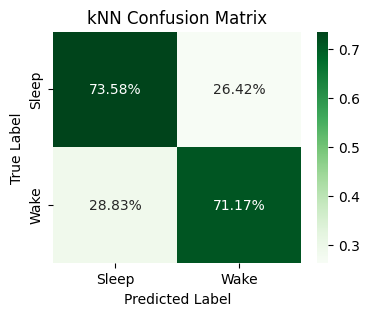

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,kNN,0.646255,0.71165,0.677378,0.735811,0.806466,0.74579,0.726047,0.433858


In [ ]:
prob_list_train, len_train, true_stages_train = compute_probabilities(
    train_sids, sw_df, final_features, 'kNN', final_knn_model, group_var
)
pred_prob_train = final_knn_model.predict_proba(X_train)
plot_cm(prob_list_train, true_list_train, 'kNN')
results_train = calculate_metrics(y_train, pred_prob_train, 'kNN')

results_train["Cohen's Kappa"] = calculate_kappa(prob_list_train, true_stages_train)

plot_cm(prob_list_train, true_stages_train, 'kNN')
results_train

Testing score:

[[3918 2865]
 [1523 3832]]


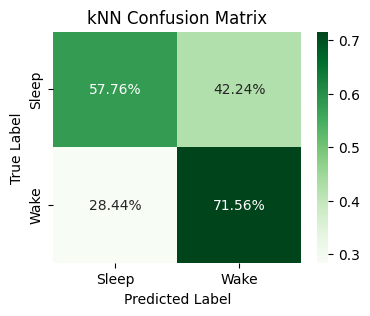

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,kNN,0.572197,0.715593,0.635911,0.577621,0.693823,0.602581,0.638491,0.255494


In [ ]:
prob_list_test, len_test, true_stages_test = compute_probabilities(
    test_sids, sw_df, final_features, 'kNN', final_knn_model, group_var
)
pred_prob_test = final_knn_model.predict_proba(X_test)
plot_cm(prob_list_test, true_list_test, 'kNN')
results_test = calculate_metrics(y_test, pred_prob_test, 'kNN')

results_test["Cohen's Kappa"] = calculate_kappa(prob_list_test, true_stages_test)

plot_cm(prob_list_test, true_stages_test, 'kNN')
results_test

#### Decision Tree

In [13]:
final_dt_model = decision_tree_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [14:23<00:00, 17.27s/trial, best loss: -0.7310804378867206]
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}


Training score:

[[29837  4449]
 [ 3951 19302]]


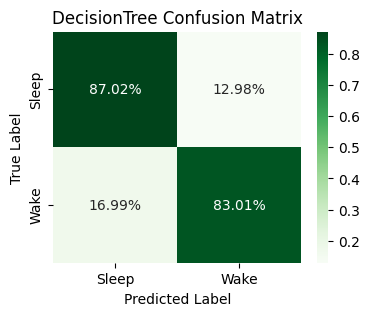

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,DecisionTree,0.812682,0.830086,0.821292,0.870239,0.929527,0.916995,0.854012,0.660719


In [18]:
prob_list_train, len_train, true_stages_train = compute_probabilities(
    train_sids, sw_df, final_features, 'DT', final_dt_model, group_var
)
pred_prob_train = final_dt_model.predict_proba(X_train)
results_train = calculate_metrics(y_train, pred_prob_train, 'DecisionTree')

results_train["Cohen's Kappa"] = calculate_kappa(prob_list_train, true_stages_train)

plot_cm(prob_list_train, true_stages_train, 'DecisionTree')
results_train

Testing score:

[[5153 1630]
 [1704 3651]]


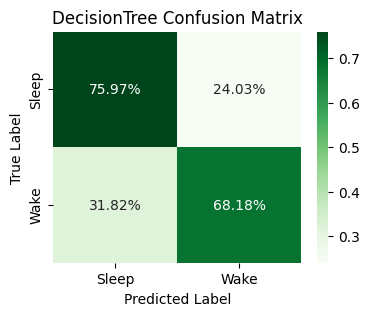

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,DecisionTree,0.691346,0.681793,0.686536,0.759693,0.807882,0.806305,0.725325,0.445397


In [19]:
prob_list_test, len_test, true_stages_test = compute_probabilities(
    test_sids, sw_df, final_features, 'DT', final_dt_model, group_var
)
pred_prob_test = final_dt_model.predict_proba(X_test)
results_test = calculate_metrics(y_test, pred_prob_test, 'DecisionTree')

results_test["Cohen's Kappa"] = calculate_kappa(prob_list_test, true_stages_test)

plot_cm(prob_list_test, true_stages_test, 'DecisionTree')
results_test

#### Random Forest

In [20]:
rf = rf_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

100%|██████████| 50/50 [21:55<00:00, 26.31s/trial, best loss: -0.743191260193876] 
Best Hyperparameters of RandomForest: {'bootstrap': 0, 'criterion': 0, 'max_depth': 10, 'max_features': 0, 'min_samples_leaf': 0.031224330524753048, 'min_samples_split': 0.17972101511898567, 'n_estimators': 411}


Training score:

[[29782  4504]
 [ 5309 17944]]


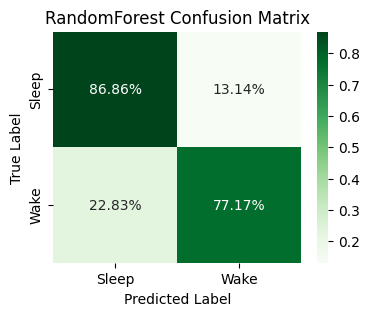

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,RandomForest,0.799359,0.771685,0.785278,0.868634,0.904513,0.88807,0.829455,0.621812


In [21]:
prob_list_train, len_train, true_stages_train = compute_probabilities(
    train_sids, sw_df, final_features, 'rf', rf, group_var
)
pred_prob_train = rf.predict_proba(X_train)
results_train = calculate_metrics(y_train, pred_prob_train, 'RandomForest')

results_train["Cohen's Kappa"] = calculate_kappa(prob_list_train, true_stages_train)

plot_cm(prob_list_train, true_stages_train, 'RandomForest')

results_train

Testing score:

[[5179 1604]
 [1506 3849]]


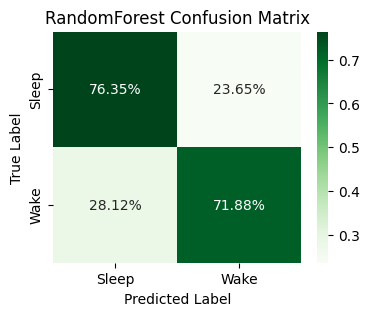

,Model,Precision,Recall,F1 Score,Specificity,AUROC,AUPRC,Accuracy,Cohen's Kappa
0,RandomForest,0.70585,0.718768,0.71225,0.763526,0.820053,0.811485,0.74378,0.469405


In [22]:
prob_list_test, len_test, true_stages_test = compute_probabilities(
    test_sids, sw_df, final_features, 'rf', rf, group_var
)

pred_prob_test = rf.predict_proba(X_test)
results_test = calculate_metrics(y_test, pred_prob_test, 'RandomForest')

results_test["Cohen's Kappa"] = calculate_kappa(prob_list_test, true_stages_test)

plot_cm(prob_list_test, true_stages_test, 'RandomForest')

results_test

### LightGBM + LSTM

#### Initial Prediction with LightGBM

In [ ]:
lgbm = lightgbm_trainer(X_train_resampled, y_train_resampled, X_val, y_val)

Training score:

In [ ]:
prob_list_train, len_train, true_stages_train = compute_probabilities(
    train_sids, sw_df, final_features, 'lgb', lgbm, group_var
)
pred_prob_train = lgbm.predict_proba(X_train)
results_train = calculate_metrics(y_train, pred_prob_train, 'LightGBM')

results_train["Cohen's Kappa"] = calculate_kappa(prob_list_train, true_stages_train)

plot_cm(prob_list_train, true_stages_train, 'LightGBM')

results_train

Testing score:

In [ ]:
prob_list_test, len_test, true_stages_test = compute_probabilities(
    test_sids, sw_df, final_features, 'lgb', lgbm, group_var
)

pred_prob_test = lgbm.predict_proba(X_test)
results_test = calculate_metrics(y_test, pred_prob_test, 'LightGBM')

results_test["Cohen's Kappa"] = calculate_kappa(prob_list_test, true_stages_test)

plot_cm(prob_list_test, true_stages_test, 'LightGBM')

results_test

Identify the best features by explaining the model using `shap` library:

In [ ]:
import shap


explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=final_features)

#### Post processing using LSTM

In [ ]:
import torch

Training process:

In [ ]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_stages_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
lstm = lstm_trainer(train_dataloader, num_epoch=80, hidden_layer_size=32, learning_rate=1e-3)

Evaluation with test set:

In [ ]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_stages_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_stages_test)
pred_arr = np.concatenate(pred_prob)

results = calculate_metrics(true_arr, pred_arr, 'LightGBM_LSTM')
results["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_stages_test, 'LightGBM_LSTM')
results

### GPBoost + Random Effects + LSTM

#### Apnea Random Effect

In [ ]:
group_vars = ['AHI_Severity', 'Obesity']

group_var = [group_vars[0]]  # selecting Apnea as random effect

(X_train_resampled, y_train_resampled, group_train_resampled), \
(X_val, y_val, group_val), \
(X_test, y_test, group_test) = process_and_resampled_data(
    sw_df, train_sids, val_sids, test_sids, final_features, group_var
)

In [ ]:
final_gpb_model = gpboost_trainer(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

##### Initial Prediction with GPBoost

In [ ]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'gpb', final_gpb_model, group_var
)
pred_prob_train = get_predicted_probabilities('gpb', final_gpb_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'GPBoost_Apnea Severity')
results_train_gpb_Apnea = get_evaluation_metrics("GPBoost_Apnea Severity", y_train, pred_prob_train, prob_list_train, true_list_train)
# save_result(results_train_gpb_Apnea, train_file)
results_train_gpb_Apnea

In [ ]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'gpb', final_gpb_model, group_var
)
pred_prob_test = get_predicted_probabilities('gpb', final_gpb_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'GPBoost_Apnea Severity')
results_test_gpb_Apnea = get_evaluation_metrics("GPBoost_Apnea Severity", y_test, pred_prob_test, prob_list_test, true_list_test)
# save_result(results_test_gpb_Apnea, test_file)
results_test_gpb_Apnea

##### Post Processing with LSTM

In [ ]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_list_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
lstm = lstm_trainer(train_dataloader, num_epoch=20, hidden_layer_size=32, learning_rate=1e-3)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_list_test)
pred_arr = np.concatenate(pred_prob)

results_test_gpb_Apnea_lstm = calculate_metrics(true_arr, pred_arr, 'GPBoost_Apnea Severity_LSTM')
results_test_gpb_Apnea_lstm["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_list_test, 'GPBoost_Apnea Severity_LSTM')

# save_result(results_test_gpb_Apnea_lstm, test_file)
results_test_gpb_Apnea_lstm

#### Obesity Random Effect

In [ ]:
group_vars = ['AHI_Severity', 'Obesity']

group_var = [group_vars[1]]  # selecting Obesity as random effect

(X_train_resampled, y_train_resampled, group_train_resampled), \
(X_val, y_val, group_val), \
(X_test, y_test, group_test) = process_and_resampled_data(
    sw_df, train_sids, val_sids, test_sids, final_features, group_var
)

In [ ]:
final_gpb_model = gpboost_trainer(X_train_resampled, group_train_resampled, y_train_resampled, X_val, y_val, group_val)

##### Initial Prediction with GPBoost

In [ ]:
prob_list_train, len_train, true_list_train = compute_probabilities(
    train_sids, sw_df, final_features, 'gpb', final_gpb_model, group_var
)
pred_prob_train = get_predicted_probabilities('gpb', final_gpb_model, X_train, group_train)
plot_cm(prob_list_train, true_list_train, 'GPBoost_Obesity')
results_train_gpb_Apnea = get_evaluation_metrics("GPBoost_Obesity", y_train, pred_prob_train, prob_list_train, true_list_train)
# save_result(results_train_gpb_Apnea, train_file)
results_train_gpb_Apnea

In [ ]:
prob_list_test, len_test, true_list_test = compute_probabilities(
    test_sids, sw_df, final_features, 'gpb', final_gpb_model, group_var
)
pred_prob_test = get_predicted_probabilities('gpb', final_gpb_model, X_test, group_test)
plot_cm(prob_list_test, true_list_test, 'GPBoost_Obesity')
results_test_gpb_Apnea = get_evaluation_metrics("GPBoost_Obesity", y_test, pred_prob_test, prob_list_test, true_list_test)
# save_result(results_test_gpb_Apnea, test_file)
results_test_gpb_Apnea

##### Post Processing with LSTM

In [ ]:
train_dataset = TimeSeriesDataset(prob_list_train, len_train, true_list_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
test_dataset = TimeSeriesDataset(prob_list_test, len_test, true_list_test)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
lstm = lstm_trainer(train_dataloader, num_epoch=20, hidden_layer_size=32, learning_rate=1e-3)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

lstm.eval()
lstm.to(device)

pred_prob = []
kappa = []

with torch.no_grad():
    for batch in test_dataloader:
        sample = batch['sample'].to(device)
        length = batch['length']
        label = batch['label'].to(device)

        outputs = lstm(sample, length)

        pred_prob.extend(outputs.cpu().numpy())

        kappa.append(
            cohen_kappa_score(
                label.cpu().numpy()[0],
                np.argmax(outputs.cpu().numpy()[0], axis=1)
            )
        )

true_arr = np.concatenate(true_list_test)
pred_arr = np.concatenate(pred_prob)

results_test_gpb_Apnea_lstm = calculate_metrics(true_arr, pred_arr, 'GPBoost_Obesity_LSTM')
results_test_gpb_Apnea_lstm["Cohen's Kappa"] = np.average(kappa)

plot_cm(pred_arr, true_list_test, 'GPBoost_Obesity_LSTM')

# save_result(results_test_gpb_Apnea_lstm, test_file)
results_test_gpb_Apnea_lstm

### Training with FT-Transformer Model (Discarded)

Here, we need to reformat the training data to integrate numerical and categorical features together:

In [ ]:
cat_features = ['AHI_Severity', 'Obesity']  # Categorical features
num_features = [
    col for col in sw_df.columns 
    if col not in cat_features and col in final_features
]  # Numerical features

In [ ]:
X_train_df = sw_df.loc[sw_df["sid"].isin(train_sids), num_features+cat_features]
y_train_df = sw_df.loc[sw_df["sid"].isin(train_sids), "Sleep_Stage"]

Do the resampling:

In [ ]:
smote = SMOTE(random_state=4487)
X_train_df, y_train_df = smote.fit_resample(X_train_df, y_train_df)

In [ ]:
X_train_num_df = X_train_df.loc[:, num_features]
X_train_cat_df = X_train_df.loc[:, cat_features]

In [ ]:
X_val_num_df = sw_df.loc[sw_df["sid"].isin(val_sids), num_features]
X_val_cat_df = sw_df.loc[sw_df["sid"].isin(val_sids), cat_features]
y_val_df = sw_df.loc[sw_df["sid"].isin(val_sids), "Sleep_Stage"]

In [ ]:
X_test_num_df = sw_df.loc[sw_df["sid"].isin(test_sids), num_features]
X_test_cat_df = sw_df.loc[sw_df["sid"].isin(test_sids), cat_features]
y_test_df = sw_df.loc[sw_df["sid"].isin(test_sids), "Sleep_Stage"]

Rescale the numerical features using 'StandardScaler':

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_num_df = scaler.fit_transform(X_train_num_df)
X_val_num_df = scaler.transform(X_val_num_df)
X_test_num_df = scaler.transform(X_test_num_df)

Transform the dataset into Tensor formats:

In [ ]:
X_train_num_tensor = torch.FloatTensor(X_train_num_df)
X_train_cat_tensor = torch.LongTensor(X_train_cat_df.to_numpy())

X_val_num_tensor = torch.FloatTensor(X_val_num_df)
X_val_cat_tensor = torch.LongTensor(X_val_cat_df.to_numpy())

X_test_num_tensor = torch.FloatTensor(X_test_num_df)
X_test_cat_tensor = torch.LongTensor(X_test_cat_df.to_numpy())

y_train_tensor = torch.LongTensor(y_train_df.to_numpy())
y_val_tensor = torch.LongTensor(y_val_df.to_numpy())
y_test_tensor = torch.LongTensor(y_test_df.to_numpy())

Define cardinalities of categorical features:

In [ ]:
cat_card = [
    len(np.unique(sw_df['AHI_Severity'])),
    len(np.unique(sw_df['Obesity']))
]

In [ ]:
print(len(X_train_num_tensor), len(X_train_cat_tensor), len(y_train_tensor))

Train FT-Transformer:

In [ ]:
model, preds, probs, labels = ft_transformer_trainer(
    X_train_num_tensor, X_val_num_tensor, 
    X_train_cat_tensor, X_val_cat_tensor,
    y_train_tensor, y_val_tensor,
    num_epochs=10,
    batch_size=32,
    learning_rate=5e-4,
    cat_cardinalities=cat_card,
    d_token=8,
    n_blocks=1,
    ffn_d_hidden=8,
    attention_dropout=0.2,
    ffn_dropout=0.2,
    residual_dropout=0.2
)

Evaluate on test set:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

test_dataset = TensorDataset(X_test_num_tensor, X_test_cat_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for num_inputs, cat_inputs, labels in test_loader:
        num_inputs = num_inputs.to(device)
        cat_inputs = cat_inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(num_inputs, cat_inputs)
        probas = torch.softmax(outputs, dim=1)
        _, pred_labels = torch.max(outputs, 1)

        all_preds.extend(pred_labels.cpu().numpy())
        all_probs.extend(probas[:, 1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test AUC: {auc:.4f}')

plot_cm(all_preds, all_labels, 'FTTransformer')